# Biodiversity Loss in Phoenix (2017-2020)
Nathalie Bonnet
### About 
Phoenix, AZ has rapidly developed in the past 20 years (Levitt and Eng 2021). This rapid urban growth threatens biodiversity and ecosystem health, urging scientists to examine how development has impacted these areas. The Biodiversity Intactness Index (BII) is an indicator of overall species biodiversity (encompassing number and abundance) in an area (Gassert et al. 2022). Here, BII data was used in tandem with Arizona geographic data to estimate areas of rich biodiversity that experienced significant loss of intactness between 2017 and 2020. 

### Highlights
- STAC catalog was used to access Microsoft Planetary Computer collections of BII data
- xarray and rioxarray libraries were used to transform the file aspects of a geodataframe
- Negative impacts on biodiversity were assessed numerically and as a visual map

### Datasets
1. 2020 Arizona TIGER shapefile
The shapefile for Arizona geographic data was accessed from data.gov and used to reference Phoenix's spatial boundary. 

Data.gov. (2021). *TIGER/Line Shapefile, 2020, State, Arizona, Census Tracts* [Dataset]. https://catalog.data.gov/dataset/tiger-line-shapefile-2020-state-arizona-census-tracts

2. Biodiversity Intactness Index Data (2017-2020)
Microsoft Planetary Computer STAC API contains spatiotemporal metadata with Earth science datasets. BII collections contained from the Phoenix area were retireved from the catalog, returning 4 items from 2017-2020. 

Microsoft Planetary Computer STAC API. (2017-2020). *BII catalog data* [Catalog]

### Github repo
 https://github.com/NatBonnet/eds220-phoenix-biodiversity

### References
Z. Levitt and J. Eng, “Where America’s developed areas are growing: ‘Way off into the horizon’,” The Washington Post, Aug. 2021, Available: https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/. [Accessed: Nov. 22, 2024]

F. Gassert, J. Mazzarello, and S. Hyde, “Global 100m Projections of Biodiversity Intactness for the years 2017-2020 [Technical Whitepaper].” Aug. 2022. Available: https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf


## Setup 
Importing libraries necessary to work with geopandas, xarray and rioxarray, and visualization

In [24]:
# Impory necessary libraries
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch

import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
from shapely import box
from shapely.geometry import Polygon


import planetary_computer
from pystac_client import Client


from IPython.display import Image 

import contextily as ctx

### Access Planetary Computer data with pystac_client

In [6]:
# Open planetary computer catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Access collections within planetary computer catalog
catalog.get_collections()

# Retrieve listed collections
collections = list(catalog.get_collections())

### Access Arizona shapefile

In [7]:
# Load in phoenix dataset
fp = os.path.join("data", "tl_2024_04_cousub", "tl_2024_04_cousub.shp")
arizona = gpd.read_file(fp)

# Clean names of columns for easier subsetting 
arizona.columns = arizona.columns.str.lower()


### Retrieve relevant objects from collections
Specify bounding coordinates for Phoenix subdivision area and timeframe for search in collection

In [9]:
# Specify bbox for Phoenix
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Specify time range of interest
time_range = "2017-01-01/2020-01-01"

# Search with given parameters for bii data
search = catalog.search(
    collections = ["io-biodiversity"], 
    bbox = bbox, 
    datetime = time_range
)

### Check returned items
We expect to get 4 objects out of the search because we specified the time range 2017-2020

In [12]:
# Get the items returned from the catalog search 
items = search.item_collection()
# Preview the items returned
items

### Obtain rioxarray items for biodiversity observations in years of interest

In [21]:
# Store items with corresponding year
ph_2017 = items[3]
ph_2020 = items[0]

# Retrieve data from item assets
bio_data_2017 = planetary_computer.sign(ph_2017.assets['data'].href)
bio_data_2020 = planetary_computer.sign(ph_2020.assets['data'].href)

# Open raster information from objects
biodiv_2017 = rioxr.open_rasterio(bio_data_2017)
biodiv_2020 = rioxr.open_rasterio(bio_data_2020)


### Arizona dataset exploration

In [10]:
# Print the head of the dataframe
arizona.head()

,statefp,countyfp,cousubfp,cousubns,geoid,geoidfq,name,namelsad,lsad,classfp,mtfcc,funcstat,aland,awater,intptlat,intptlon,geometry
0,04,005,91198,01934931,0400591198,0600000US0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,S,12231962349,44576380,+35.1066122,-111.3662507,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,0600000US0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,S,7228864156,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,0600000US0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."
3,04,023,92295,01934961,0402392295,0600000US0402392295,Nogales,Nogales CCD,22,Z5,G4040,S,1762339489,2382710,+31.4956020,-111.0171332,"POLYGON ((-111.36692 31.52136, -111.36316 31.5..."
4,04,023,92550,01934966,0402392550,0600000US0402392550,Patagonia,Patagonia CCD,22,Z5,G4040,S,1439560139,685527,+31.5664619,-110.6410279,"POLYGON ((-110.96273 31.68695, -110.96251 31.6..."


In [18]:
# Check the CRS of the dataset
print(f"CRS of Arizona dataset: {arizona.crs}")

CRS of Arizona dataset: EPSG:4269


### Subset Arizona spatial data to only Phoenix area

In [20]:
# Subset to Phoenix area
phoenix = arizona[arizona.name == "Phoenix"]

# Check that subsetting worked
phoenix.name.unique()

array(['Phoenix'], dtype=object)

## Clip biodiversity data by Phoenix area boundaries

In [22]:
# Create clipped biodiversity observations within Phoenix area
clip_2017 = biodiv_2017.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry)
clip_2020 = biodiv_2020.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry)


### Confirm that biodiversity data clipped appropriately

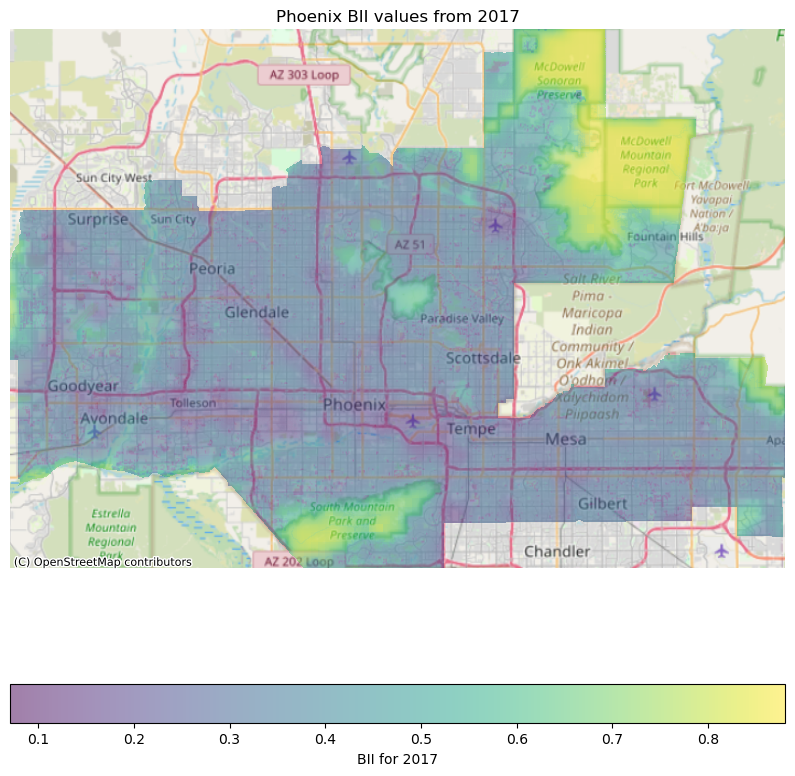

In [33]:
# Visualize where bii data is being clipped to
fig, ax = plt.subplots(figsize=(10, 10))
# Plot 2017 observations
clip_2017.plot(ax=ax, alpha = 0.5, cbar_kwargs = {'location':'bottom', 'label':'BII for 2017'})
# Add basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs = arizona.crs)
# Set title
ax.set_title("Phoenix BII values from 2017")
# Remove axes
ax.axis('off')
plt.show()

### Create boolean xarray to quantify biodiversity loss
Raster cells with BII values equal to or above 0.75 will return as 'True', and any below those high biodiversity sites will be categorized as 'False'

In [35]:
# Use boolean argument to reclassify cells
bii_2017 = clip_2017 >= 0.75
bii_2020 = clip_2020 >= 0.75

### Calculate the percentage of high biodiversity areas in Phoenix between 2017 and 2020

In [53]:
# Find the percentage of area in Phoenix with a biodiversity index value of 0.75 or greater in 2017
perc_2017 = bii_2017.sum()/bii_2017.count()*100
print(f"Percent of high biodiversity area in Phoenix in 2017: {np.array(perc_2017).tolist():.2f}%")

Percent of high biodiversity area in Phoenix in 2017: 4.18%


In [54]:
perc_2020 = bii_2020.sum()/bii_2020.count()*100
print(f"Percent of high biodiversity area in Phoenix in 2020: {np.array(perc_2020).tolist():.2f}%")

Percent of high biodiversity area in Phoenix in 2020: 3.81%


### Find areas of large biodiversity loss

- Convert boolean arguments to numeric binary (0,1)

In [ ]:
# Convert boolean values to binary arguments
bii_2017_int = bii_2017.astype(int)
bii_2020_int = bii_2020.astype(int)

- Retrieving cells where there were BII values are greater than 0.75 in 2017 and not in 2020 

In [43]:
bii_chng = bii_2017_int - bii_2020_int

- Subset to only nonzero cells. This will allow us to plot just the areas of decreased biosdiversity

In [44]:
bii_chng = bii_chng.where(bii_chng != 0)

## Create final visualization of BII change over 4 years in Phoenix

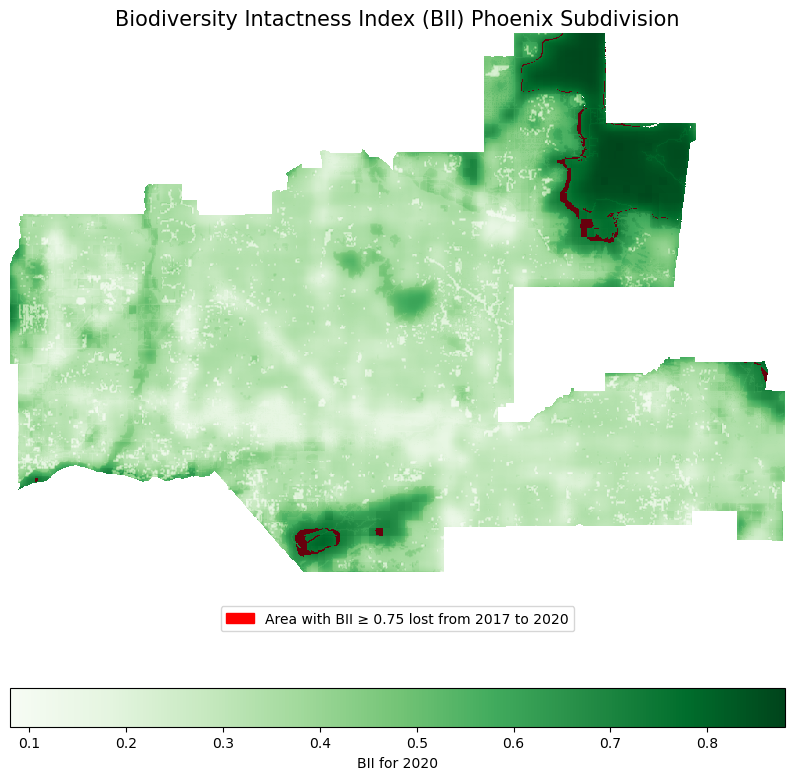

In [ ]:
# Add patch and label indicating change area meaning
legend_elements = [patch.Patch(facecolor='red', edgecolor='r', label='Area with BII ≥ 0.75 lost from 2017 to 2020')]

# Plot 2017 biodiversity values against areas that had a signficant decrease
fig, ax = plt.subplots(figsize = (10,10))
ax.axis("off")
clip_2020.plot(ax=ax, cmap ="Greens", cbar_kwargs = {'location':'bottom', 'label':'BII for 2020'})
bii_chng.plot(ax=ax, cmap = "Reds", add_colorbar = False)
ax.legend(handles=legend_elements, 
loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=5)
# Labels, title, and legend
ax.set_ylabel(" ")
ax.set_title("Biodiversity Intactness Index (BII) Phoenix Subdivision",
             {'fontsize':15})

plt.show()

## Create contrasting plot to visualize any areas with positive change

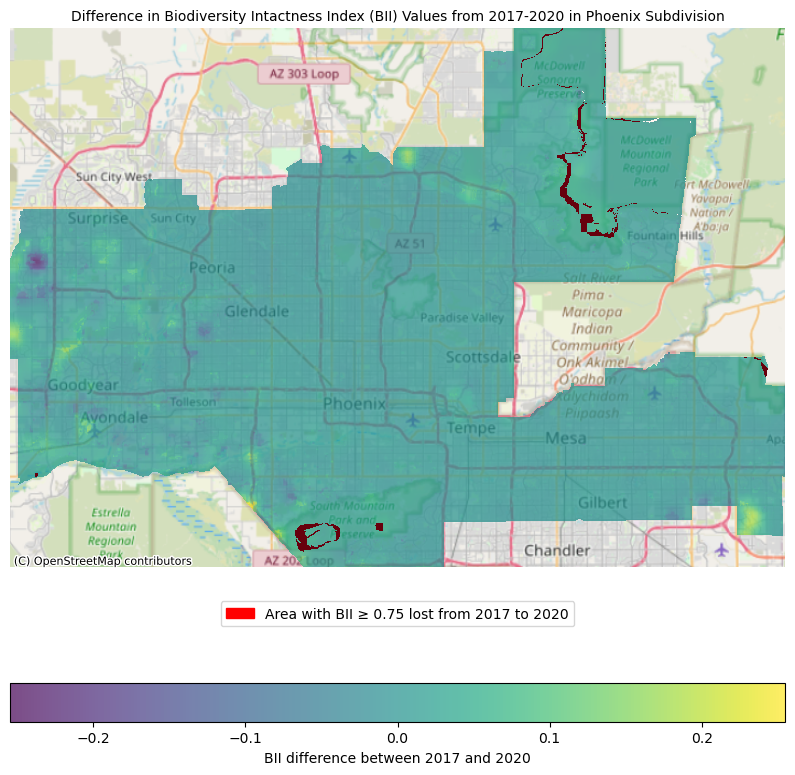

In [67]:
# Take difference in rasters 2017-2020
diff_clip = clip_2017 - clip_2020

# Plot difference raster
fig, ax = plt.subplots(figsize = (10,10))
ax.axis("off")
diff_clip.plot(ax=ax, cmap ="viridis", alpha = 0.7, cbar_kwargs = {'location':'bottom', 'label':'BII difference between 2017 and 2020'})
bii_chng.plot(ax=ax, cmap = "Reds" , add_colorbar = False)
# Add basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs = arizona.crs)
ax.legend(handles=legend_elements, 
loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=5)
# Labels, title, and legend
ax.set_ylabel(" ")
ax.set_title("Difference in Biodiversity Intactness Index (BII) Values from 2017-2020 in Phoenix Subdivision",
             {'fontsize':10})

plt.show()

## Discussion
From the calculation of the percentages of total area in Phoenix with BII greater than or equal to 0.75, we know that the percent of area at this high level of biodviersity went down in the urban area. The difference was about 0.4%. To compare the area with the total change in biodiversity, the difference of index values was plotted between years with the areas of interest overlaid on the basemap of the Phoenix area. Interestingly, we can see that the areas of land that experienced biodiversity loss were within or near a regional park and preserve area. Though we were interested in the negative effects of urbanization, comparing these areas with overall index value change across the area shows that the biodiversity in some areas increased, most noteably in the Western edge of the Phoenix area near large urban areas. It is unclear from the data alone what may have led to this pattern. However, it might be that in areas with greater reported biodiversity there were simply more reported species observations with an increase in residents. 